In [1]:
!pip install pyevtk

In [19]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import torch
from torch.autograd import grad,Variable
import numpy as np
import numpy.random as npr
from matplotlib import pyplot as plt
import matplotlib as mpl
import time
import scipy as sp
from pyevtk.hl import gridToVTK

In [3]:
# ------------------------------ network settings ---------------------------------------------------
iteration = 20
D_in = 2
H = 30
D_out = 2
lr = 0.1
# ------------------------------ material parameter -------------------------------------------------
model_energy = 'NeoHookean2D'
E = 1000
nu = 0.3
param_c1 = 630
param_c2 = -1.2
param_c = 100
# ----------------------------- define structural parameters ---------------------------------------
Length = 4.0
Height = 1.0
Depth = 1.0
known_left_ux = 0
known_left_uy = 0
bc_left_penalty = 1.0

known_right_tx = 0
known_right_ty = -5.0
bc_right_penalty = 1.0
# ------------------------------ define domain and collocation points -------------------------------
Nx = 200 # 120  # 120
Ny = 50 # 30  # 60
x_min, y_min = (0.0, 0.0)
hx = Length / (Nx - 1)
hy = Height / (Ny - 1)
shape = [Nx, Ny]
dxdy = [hx, hy]

# ------------------------------ data testing -------------------------------------------------------
num_test_x = 200
num_test_y = 50

In [4]:
dev = torch.device('cpu')
if torch.cuda.is_available():
    print("CUDA is available, running on GPU")
    dev = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    print("CUDA not available, running on CPU")

CUDA not available, running on CPU


In [5]:
mpl.rcParams['figure.dpi'] = 350
# fix random seeds
axes = {'labelsize' : 'large'}
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 17}
legend = {'fontsize': 'medium'}
lines = {'linewidth': 3,
         'markersize' : 7}
mpl.rc('font', **font)
mpl.rc('axes', **axes)
mpl.rc('legend', **legend)
mpl.rc('lines', **lines)

In [6]:
def setup_domain():
    x_dom = x_min, Length, Nx
    y_dom = y_min, Height, Ny
    # create points
    lin_x = np.linspace(x_dom[0], x_dom[1], x_dom[2])
    lin_y = np.linspace(y_dom[0], y_dom[1], y_dom[2])
    dom = np.zeros((Nx * Ny, 2))
    c = 0
    for x in np.nditer(lin_x):
        tb = y_dom[2] * c
        te = tb + y_dom[2]
        c += 1
        dom[tb:te, 0] = x
        dom[tb:te, 1] = lin_y
    print(dom.shape)
    fig = plt.figure(figsize=(5, 1))
    ax = fig.add_subplot(111)
    ax.scatter(dom[:, 0], dom[:, 1], s=0.005, facecolor='black')
    ax.set_xlabel('X', fontsize=3)
    ax.set_ylabel('Y', fontsize=3)
    ax.tick_params(labelsize=4)
    # ------------------------------------ BOUNDARY ----------------------------------------
    # Left boundary condition (Dirichlet BC)
    bcl_u_pts_idx = np.where(dom[:, 0] == x_min)
    bcl_u_pts = dom[bcl_u_pts_idx, :][0]
    bcl_u = np.ones(np.shape(bcl_u_pts)) * [known_left_ux, known_left_uy]

    # Right boundary condition (Neumann BC)
    bcr_t_pts_idx = np.where(dom[:, 0] == Length)
    bcr_t_pts = dom[bcr_t_pts_idx, :][0]
    bcr_t = np.ones(np.shape(bcr_t_pts)) * [known_right_tx, known_right_ty]

    ax.scatter(dom[:, 0], dom[:, 1], s=0.005, facecolor='blue')
    ax.scatter(bcl_u_pts[:, 0], bcl_u_pts[:, 1], s=0.5, facecolor='red')
    ax.scatter(bcr_t_pts[:, 0], bcr_t_pts[:, 1], s=0.5, facecolor='green')
    plt.savefig('Domain2DBeam.pdf')
    plt.show()

    boundary_neumann = {
        # condition on the right
        "neumann_1": {
            "coord": bcr_t_pts,
            "known_value": bcr_t,
            "penalty": bc_right_penalty
        }
        # adding more boundary condition here ...
    }
    boundary_dirichlet = {
        # condition on the left
        "dirichlet_1": {
            "coord": bcl_u_pts,
            "known_value": bcl_u,
            "penalty": bc_left_penalty
        }
        # adding more boundary condition here ...
    }
    return dom, boundary_neumann, boundary_dirichlet


# -----------------------------------------------------------------------------------------------------
# prepare inputs for testing the model
# -----------------------------------------------------------------------------------------------------
def get_datatest(Nx=num_test_x, Ny=num_test_y):
    x_dom_test = x_min, Length, Nx
    y_dom_test = y_min, Height, Ny
    # create points
    x_space = np.linspace(x_dom_test[0], x_dom_test[1], x_dom_test[2])
    y_space = np.linspace(y_dom_test[0], y_dom_test[1], y_dom_test[2])
    xGrid, yGrid = np.meshgrid(x_space, y_space)
    data_test = np.concatenate(
        (np.array([xGrid.flatten()]).T, np.array([yGrid.flatten()]).T), axis=1)
    return x_space, y_space, data_test

(10000, 2)


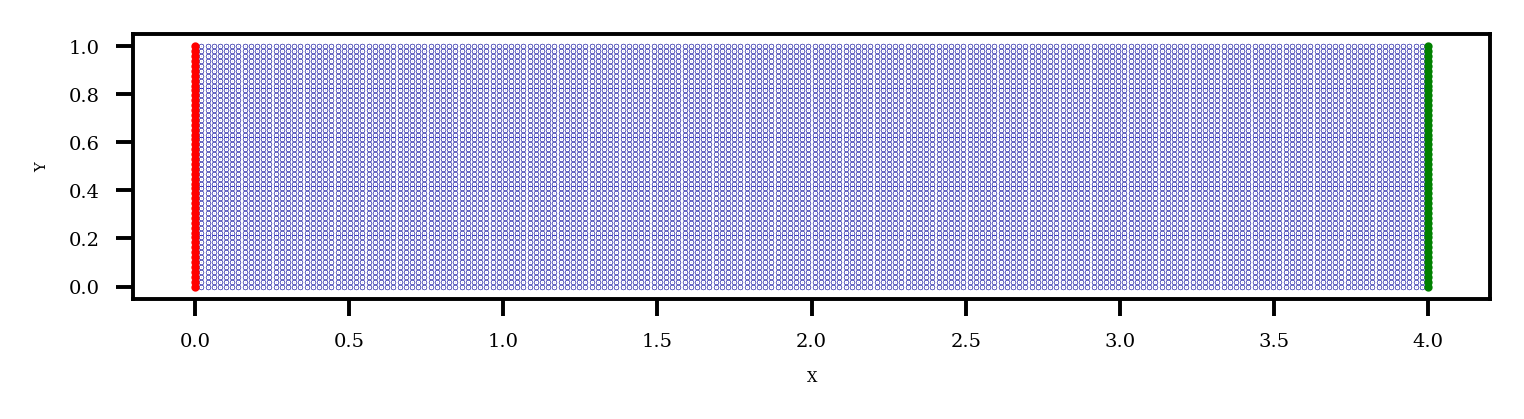

In [7]:
if __name__ == '__main__':
  setup_domain()

In [8]:
model = torch.nn.Sequential(
          torch.nn.Linear(D_in,H),
          torch.nn.Tanh(),
          torch.nn.Linear(H,H),
          torch.nn.Tanh(),
          torch.nn.Linear(H,H),
          torch.nn.Tanh(),
          torch.nn.Linear(H,D_out),
)

model = model.to(dev)

In [9]:
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=30, bias=True)
  (1): Tanh()
  (2): Linear(in_features=30, out_features=30, bias=True)
  (3): Tanh()
  (4): Linear(in_features=30, out_features=30, bias=True)
  (5): Tanh()
  (6): Linear(in_features=30, out_features=2, bias=True)
)


In [10]:
def energy2D(u, x):
  mu = E / (2 * (1 + nu))
  lam = (E * nu) / ((1 + nu) * (1 - 2 * nu))
  duxdxy = grad(u[:, 0].unsqueeze(1), x, torch.ones(x.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
  duydxy = grad(u[:, 1].unsqueeze(1), x, torch.ones(x.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
  Fxx = duxdxy[:, 0].unsqueeze(1) + 1
  Fxy = duxdxy[:, 1].unsqueeze(1) + 0
  Fyx = duydxy[:, 0].unsqueeze(1) + 0
  Fyy = duydxy[:, 1].unsqueeze(1) + 1
  detF = Fxx * Fyy - Fxy * Fyx
  trC = Fxx ** 2 + Fxy ** 2 + Fyx ** 2 + Fyy ** 2
  strainEnergy = 0.5 * lam * (torch.log(detF) * torch.log(detF)) - mu * torch.log(detF) + 0.5 * mu * (trC - 2)
  return strainEnergy

In [11]:
def getU(x):
  u = model(x)
  Ux = x[:, 0] * u[:, 0]
  Uy = x[:, 0] * u[:, 1]
  Ux = Ux.reshape(Ux.shape[0], 1)
  Uy = Uy.reshape(Uy.shape[0], 1)
  u_pred = torch.cat((Ux, Uy), -1)
  return u_pred

In [12]:
def lossInternalEnergy(f, x=None, dx=1.0, dy=1.0, dz=1.0, shape=None):
    return approxIntegration(f, x, dx, dy, dz, shape)

def lossExternalEnergy(f, x=None, dx=1.0, dy=1.0, dz=1.0, shape=None):
    if x is not None:
        return trapz1D(f, x=x)
    else:
        return trapz1D(f, dx=dx)

def approxIntegration(f, x=None, dx=1.0, dy=1.0, dz=1.0, shape=None):
    if x is not None:
        return trapz2D(f, xy=x, shape=shape)
    else:
        return trapz2D(f, dx=dx, dy=dy, shape=shape)

def trapz1D(y, x=None, dx=1.0, axis=-1):
    y1D = y.flatten()
    if x is not None:
        x1D = x.flatten()
        return trapz(y1D, x1D, dx=dx, axis=axis)
    else:
        return trapz(y1D, dx=dx)

def trapz2D(f, xy=None, dx=None, dy=None, shape=None):
    f2D = f.reshape(shape[0], shape[1])
    if dx is None and dy is None:
        x = xy[:, 0].flatten().reshape(shape[0], shape[1])
        y = xy[:, 1].flatten().reshape(shape[0], shape[1])
        return trapz(trapz(f2D, y[0, :]), x[:, 0])
    else:
        return trapz(trapz(f2D, dx=dy), dx=dx)


def trapz(y, x=None, dx=1.0, axis=-1):
    # y = np.asanyarray(y)
    if x is None:
        d = dx
    else:
        d = x[1:] - x[0:-1]
        # reshape to correct shape
        shape = [1] * y.ndimension()
        shape[axis] = d.shape[0]
        d = d.reshape(shape)
    nd = y.ndimension()
    slice1 = [slice(None)] * nd
    slice2 = [slice(None)] * nd
    slice1[axis] = slice(1, None)
    slice2[axis] = slice(None, -1)
    ret = torch.sum(d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0, axis)
    return ret

def loss_squared_sum(tinput, target):
    row, column = tinput.shape
    loss = 0
    for j in range(column):
        loss += torch.sum((tinput[:, j] - target[:, j]) ** 2) / tinput[:, j].data.nelement()
    return loss

In [13]:
def my_custon_train(shape, dxdy, data, neumannBC, dirichletBC, iteration, learning_rate):
    x = torch.from_numpy(data).float()
    x = x.to(dev)
    x.requires_grad_(True)
    optimizer = torch.optim.LBFGS(model.parameters(), lr=learning_rate, max_iter=20)
    start_time = time.time()

    energy_loss_array = []
    boundary_loss_array = []
    loss_array = []
    current_Time = time.time()

    dirBC_coordinates = {}  # declare a dictionary
    dirBC_values = {}  # declare a dictionary
    dirBC_penalty = {}
    for i, keyi in enumerate(dirichletBC):
        dirBC_coordinates[i] = torch.from_numpy(dirichletBC[keyi]['coord']).float().to(dev)
        dirBC_values[i] = torch.from_numpy(dirichletBC[keyi]['known_value']).float().to(dev)
        dirBC_penalty[i] = torch.tensor(dirichletBC[keyi]['penalty']).float().to(dev)
    # -------------------------------------------------------------------------------
    #                           Neumann BC
    # -------------------------------------------------------------------------------
    neuBC_coordinates = {}  # declare a dictionary
    neuBC_values = {}  # declare a dictionary
    neuBC_penalty = {}
    for i, keyi in enumerate(neumannBC):
        neuBC_coordinates[i] = torch.from_numpy(neumannBC[keyi]['coord']).float().to(dev)
        neuBC_coordinates[i].requires_grad_(True)
        neuBC_values[i] = torch.from_numpy(neumannBC[keyi]['known_value']).float().to(dev)
        neuBC_penalty[i] = torch.tensor(neumannBC[keyi]['penalty']).float().to(dev)
        
    for t in range(iteration):
      def closure(): #purpose is to clear the gradient,compute the loss and return it
        it_time = time.time()

        u_pred = getU(x)
        u_pred.double()
        storedEnergy = energy2D(u_pred, x)
        internal2 = lossInternalEnergy(storedEnergy, dx=dxdy[0], dy=dxdy[1], shape=shape)
        external2 = torch.zeros(len(neuBC_coordinates))

        for i, vali in enumerate(neuBC_coordinates):
            neu_u_pred = getU(neuBC_coordinates[i])
            fext = torch.bmm((neu_u_pred + neuBC_coordinates[i]).unsqueeze(1), neuBC_values[i].unsqueeze(2))
            external2[i] = lossExternalEnergy(fext, dx=dxdy[1])
        bc_u_crit = torch.zeros((len(dirBC_coordinates)))
        for i, vali in enumerate(dirBC_coordinates):
            dir_u_pred = getU(dirBC_coordinates[i])
            bc_u_crit[i] = loss_squared_sum(dir_u_pred, dirBC_values[i])

        energy_loss = internal2 - torch.sum(external2)
        boundary_loss = torch.sum(bc_u_crit)
        loss = internal2 - torch.sum(external2) + boundary_loss
        optimizer.zero_grad()
        loss.backward()
        print('Iter: %d Loss: %.9e Energy: %.9e Boundary: %.9e Time: %.3e'
              % (t + 1, loss.item(), energy_loss.item(), boundary_loss.item(), time.time() - it_time))
        energy_loss_array.append(energy_loss.data)
        boundary_loss_array.append(boundary_loss.data)
        loss_array.append(loss.data)
        return loss
      optimizer.step(closure)
    timeOfTraining = time.time() - start_time
    print('Training Time is : %.4f'% (timeOfTraining))
    end_time = time.time() - start_time
    print("End time: %.5f" % end_time)

(10000, 2)


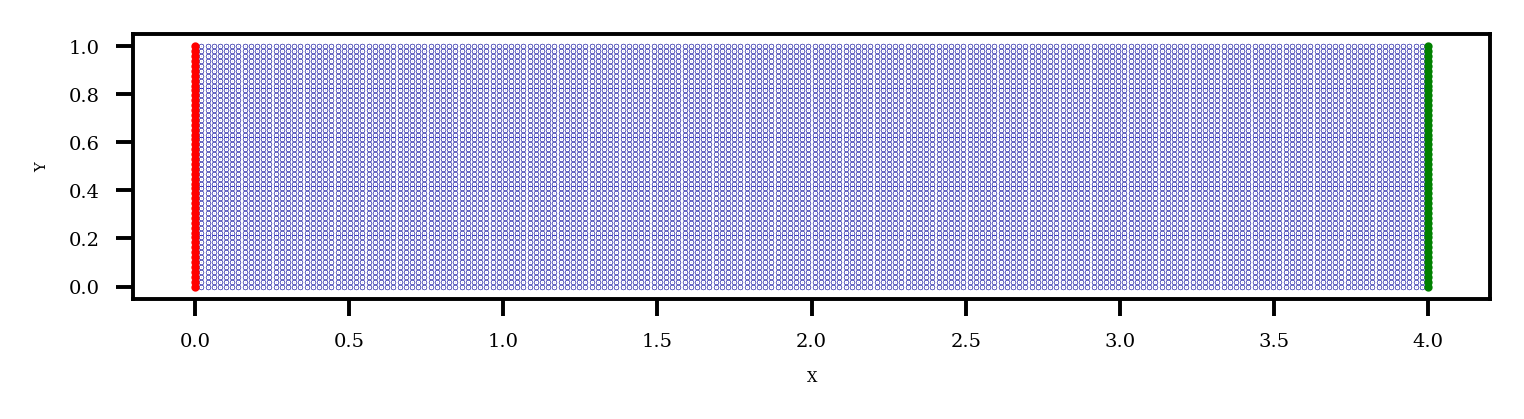

Iter: 1 Loss: 1.310233765e+02 Energy: 1.310233765e+02 Boundary: 0.000000000e+00 Time: 1.312e-01
Iter: 1 Loss: 1.201390610e+02 Energy: 1.201390610e+02 Boundary: 0.000000000e+00 Time: 4.235e-02
Iter: 1 Loss: 1.034765091e+02 Energy: 1.034765091e+02 Boundary: 0.000000000e+00 Time: 4.231e-02
Iter: 1 Loss: 8.858730316e+01 Energy: 8.858730316e+01 Boundary: 0.000000000e+00 Time: 5.093e-02
Iter: 1 Loss: 7.534600067e+01 Energy: 7.534600067e+01 Boundary: 0.000000000e+00 Time: 4.480e-02
Iter: 1 Loss: 6.373530960e+01 Energy: 6.373530960e+01 Boundary: 0.000000000e+00 Time: 4.811e-02
Iter: 1 Loss: 5.369086838e+01 Energy: 5.369086838e+01 Boundary: 0.000000000e+00 Time: 4.200e-02
Iter: 1 Loss: 4.510887909e+01 Energy: 4.510887909e+01 Boundary: 0.000000000e+00 Time: 4.146e-02
Iter: 1 Loss: 3.785630035e+01 Energy: 3.785630035e+01 Boundary: 0.000000000e+00 Time: 4.873e-02
Iter: 1 Loss: 3.178345680e+01 Energy: 3.178345680e+01 Boundary: 0.000000000e+00 Time: 4.073e-02
Iter: 1 Loss: 2.673612213e+01 Energy: 2.

In [14]:
dom, boundary_neumann, boundary_dirichlet = setup_domain()
my_custon_train(shape, dxdy, dom, boundary_neumann, boundary_dirichlet, iteration, lr)

In [15]:
def evaluate_model( x, y, z):
  mu = E / (2 * (1 + nu))
  lmbda = (E * nu) / ((1 + nu) * (1 - 2 * nu))
  Nx = len(x)
  Ny = len(y)
  xGrid, yGrid = np.meshgrid(x, y)
  x1D = xGrid.flatten()
  y1D = yGrid.flatten()
  xy = np.concatenate((np.array([x1D]).T, np.array([y1D]).T), axis=-1)
  xy_tensor = torch.from_numpy(xy).float()
  xy_tensor = xy_tensor.to(dev)
  xy_tensor.requires_grad_(True)
  u_pred_torch = getU(xy_tensor)
  duxdxy = grad(u_pred_torch[:, 0].unsqueeze(1), xy_tensor, torch.ones(xy_tensor.size()[0], 1, device=dev),
                  create_graph=True, retain_graph=True)[0]
  duydxy = grad(u_pred_torch[:, 1].unsqueeze(1), xy_tensor, torch.ones(xy_tensor.size()[0], 1, device=dev),
                  create_graph=True, retain_graph=True)[0]
  F11 = duxdxy[:, 0].unsqueeze(1) + 1
  F12 = duxdxy[:, 1].unsqueeze(1) + 0
  F21 = duydxy[:, 0].unsqueeze(1) + 0
  F22 = duydxy[:, 1].unsqueeze(1) + 1
  detF = F11 * F22 - F12 * F21
  invF11 = F22 / detF
  invF22 = F11 / detF
  invF12 = -F12 / detF
  invF21 = -F21 / detF
  C11 = F11**2 + F21**2
  C12 = F11*F12 + F21*F22
  C21 = F12*F11 + F22*F21
  C22 = F12**2 + F22**2
  E11 = 0.5 * (C11 - 1)
  E12 = 0.5 * C12
  E21 = 0.5 * C21
  E22 = 0.5 * (C22 - 1)

  P11 = mu * F11 + (lmbda * torch.log(detF) - mu) * invF11
  P12 = mu * F12 + (lmbda * torch.log(detF) - mu) * invF21
  P21 = mu * F21 + (lmbda * torch.log(detF) - mu) * invF12
  P22 = mu * F22 + (lmbda * torch.log(detF) - mu) * invF22

  S11 = invF11 * P11 + invF12 * P21
  S12 = invF11 * P12 + invF12 * P22
  S21 = invF21 * P11 + invF22 * P21
  S22 = invF21 * P12 + invF22 * P22
  u_pred = u_pred_torch.detach().cpu().numpy()
  F11_pred = F11.detach().cpu().numpy()
  F12_pred = F12.detach().cpu().numpy()
  F21_pred = F21.detach().cpu().numpy()
  F22_pred = F22.detach().cpu().numpy()
  E11_pred = E11.detach().cpu().numpy()
  E12_pred = E12.detach().cpu().numpy()
  E21_pred = E21.detach().cpu().numpy()
  E22_pred = E22.detach().cpu().numpy()
  S11_pred = S11.detach().cpu().numpy()
  S12_pred = S12.detach().cpu().numpy()
  S21_pred = S21.detach().cpu().numpy()
  S22_pred = S22.detach().cpu().numpy()
  surUx = u_pred[:, 0].reshape(Ny, Nx, 1)
  surUy = u_pred[:, 1].reshape(Ny, Nx, 1)
  surUz = np.zeros([Nx, Ny, 1])
  surE11 = E11_pred.reshape(Ny, Nx, 1)
  surE12 = E12_pred.reshape(Ny, Nx, 1)
  surE13 = np.zeros([Nx, Ny, 1])
  surE21 = E21_pred.reshape(Ny, Nx, 1)
  surE22 = E22_pred.reshape(Ny, Nx, 1)
  surE23 = np.zeros([Nx, Ny, 1])
  surE33 = np.zeros([Nx, Ny, 1])
  surS11 = S11_pred.reshape(Ny, Nx, 1)
  surS12 = S12_pred.reshape(Ny, Nx, 1)
  surS13 = np.zeros([Nx, Ny, 1])
  surS21 = S21_pred.reshape(Ny, Nx, 1)
  surS22 = S22_pred.reshape(Ny, Nx, 1)
  surS23 = np.zeros([Nx, Ny, 1])
  surS33 = np.zeros([Nx, Ny, 1])
  SVonMises = np.float64(np.sqrt(0.5 * ((surS11 - surS22) ** 2 + (surS22) ** 2 + (-surS11) ** 2 + 6 * (surS12 ** 2))))
  U = (np.float64(surUx), np.float64(surUy), np.float64(surUz))
  return U, np.float64(surS11), np.float64(surS12), np.float64(surS13), np.float64(surS22), np.float64(
      surS23), \
          np.float64(surS33), np.float64(surE11), np.float64(surE12), \
          np.float64(surE13), np.float64(surE22), np.float64(surE23), np.float64(surE33), np.float64(
      SVonMises), \
          np.float64(F11_pred), np.float64(F12_pred), np.float64(F21_pred), np.float64(F22_pred)

In [16]:
def getL2norm2D(surUx, surUy, Nx, Ny, hx, hy):
    uX1D = surUx.flatten()
    uY1D = surUy.flatten()
    uXY = np.concatenate((np.array([uX1D]).T, np.array([uY1D]).T), axis=-1)
    N = Nx * Ny
    udotu = np.zeros(N)
    for i in range(N):
        udotu[i] = np.dot(uXY[i, :], uXY[i, :].T)
    udotuTensor = udotu.reshape(Nx, Ny)
    # ||u||_L^2 = \sqrt(\int (u.u))
    L2norm = np.sqrt(np.trapz(np.trapz(udotuTensor, dx=hy), dx=hx))
    # L2norm = np.sqrt(sp.simps(sp.simps(udotuTensor, dx=hy), dx=hx))
    return L2norm

def getH10norm2D(F11, F12, F21, F22, Nx, Ny, hx, hy):
    FinnerF = (F11 - 1) ** 2 + F12 ** 2 + F21 ** 2 + (F22 - 1) ** 2
    FinnerFTensor = FinnerF.reshape(Nx, Ny)
    H10norm = np.sqrt(np.trapz(np.trapz(FinnerFTensor, dx=hy), dx=hx))
    # H10norm = np.sqrt(sp.simps(sp.simps(FinnerFTensor, dx=hy), dx=hx))
    return H10norm

In [22]:
def write_vtk_v2(filename, x_space, y_space, z_space, U, S11, S12, S13, S22, S23, S33, E11, E12, E13, E22, E23, E33, SVonMises):
    xx, yy, zz = np.meshgrid(x_space, y_space, z_space)
    gridToVTK(filename, xx, yy, zz, pointData={"displacement": U, "S-VonMises": SVonMises, \
                                               "S11": S11, "S12": S12, "S13": S13, \
                                               "S22": S22, "S23": S23, "S33": S33, \
                                               "E11": E11, "E12": E12, "E13": E13, \
                                               "E22": E22, "E23": E23, "E33": E33\
                                               })

In [23]:
x, y, datatest = get_datatest()
z = np.array([0])
filename_out = "/gdrive/MyDrive/Colab Notebooks/BTP/2DBemaTrapz"
U, S11, S12, S13, S22, S23, S33, E11, E12, E13, E22, E23, E33, SVonMises, F11, F12, F21, F22 = evaluate_model(x, y, z)
write_vtk_v2(filename_out, x, y, z, U, S11, S12, S13, S22, S23, S33, E11, E12, E13, E22, E23, E33, SVonMises)
surUx, surUy, surUz = U
L2norm = getL2norm2D(surUx, surUy, Nx, Ny, hx, hy)
H10norm = getH10norm2D(F11, F12, F21, F22, Nx, Ny, hx, hy)
print("L2 norm = %.10f" % L2norm)
print("H10 norm = %.10f" % H10norm)

L2 norm = 1.1103897128
H10 norm = 0.8524240930
